In [1]:
cd '/content/drive/MyDrive/Colab Notebooks/Mutimedia/DVC'

/content/drive/MyDrive/Colab Notebooks/Mutimedia/DVC


In [2]:
cd ./TestDemo/VideoCodec

/content/drive/MyDrive/Colab Notebooks/Mutimedia/DVC/TestDemo/VideoCodec


# Encoder

In [3]:
import pickle
import os
from cv2 import imread
import pandas as pd
import numpy as np

In [4]:
!pip install tensorflow==1.14.0

In [5]:
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [7]:
!python  Encoder.py --EncoderModel './model/L1024/frozen_model_E.pb'  --input_frame './image/im002.png' --refer_frame  './image/im003.png'	--output './output_L1024/'

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Decoder

In [8]:
import math
import cv2
from matplotlib import pyplot as plt

In [9]:
def CalcuPSNR(target, ref):
    diff = ref - target
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff**2.))
    return 20 * math.log10(1.0 / (rmse))


def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [10]:
(loadmodel, refer_path, outputfolder) = ('./model/L1024/frozen_model_D.pb', './image/im003.png', './output_L1024/')

In [11]:
graph = load_graph(loadmodel)

reconframe = graph.get_tensor_by_name('import/build_towers/tower_0/train_net_inference_one_pass/train_net/ReconFrame:0')
res_input = graph.get_tensor_by_name('import/quant_feature:0')
res_prior_input = graph.get_tensor_by_name('import/quant_z:0')
motion_input = graph.get_tensor_by_name('import/quant_mv:0')
previousImage = graph.get_tensor_by_name('import/input_image_ref:0')

with tf.Session(graph=graph) as sess:

    with open(outputfolder + 'quantized_res_feature.pkl', 'rb') as f:
        residual_feature = pd.read_pickle(f)

    with open(outputfolder + 'quantized_res_prior_feature.pkl', 'rb') as f:
        residual_prior_feature = pd.read_pickle(f)

    with open(outputfolder + 'quantized_motion_feature.pkl', 'rb') as f:
        motion_feature = pd.read_pickle(f)

    im1 = imread(refer_path)
    im1 = im1 / 255.0
    im1 = np.expand_dims(im1, axis=0)

    # reconstructed image
    recon_d = sess.run(
        [reconframe],
        feed_dict={
            res_input: residual_feature,
            res_prior_input: residual_prior_feature,
            motion_input: motion_feature,
            previousImage: im1
        })

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


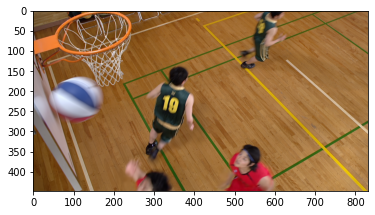

In [12]:
recon_d = np.array(recon_d)
plt.imshow(cv2.cvtColor(recon_d[0,0], cv2.COLOR_BGR2RGB))

In [13]:
imagedir = './image/'
im2 = cv2.imread(imagedir + 'im002.png')
im2 = im2 / 255.0
im2 = np.expand_dims(im2, axis=0)
print(CalcuPSNR(im2, recon_d))

37.31445158635154
